### Imports, datasets and helper functions

In [1]:
import pickle, json
from datetime import date, timedelta, datetime

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from functools import partial
import multiprocessing
from multiprocessing import Pool
num_core = max(multiprocessing.cpu_count()-1,1)

import gc

import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
from utils import prep_holdout_set, get_timespan_15, gen_features, gen_test_features, prep_dataset
from utils import TIME_FEATURES, NUM_LABELS, NUM_REQ

In [3]:
df = pd.read_csv("../data_temp/training_transformed.csv") # "data/df_transformed_simple_fill_noise.csv"
df = df.set_index('geohash6')
df.columns = pd.DatetimeIndex(df.columns)
# df = df.replace(-1, 0)

cluster_df = pd.read_csv("../data_temp/cluster_df.csv")
cluster_df = cluster_df.set_index('geohash6')

# we use last 7 days (25/5 - 31/5) as holdout set
df_raw = pd.read_csv("../data_temp/training_timestamps.csv") # training.csv but with parsed datetime, generated during Preprocessing
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
df_holdout_raw = df_raw.loc[(df_raw.datetime>pd.datetime(2019,5, 25, 0, 0)) & (df_raw.datetime<pd.datetime(2019,5, 31, 22, 15))] 
# require 5 labels, dataset ends at 31/5 2345

### Create intermediate holdout set
#### from which to extract holdout features

In [4]:
# frac to speed up, tests show not much difference in performance

df_holdout_raw = df_holdout_raw.sample(frac=0.1, random_state=8) 

# Split into partitions for multiprocessing
partition_size = math.floor(len(df_holdout_raw.index) / num_core)
holdout_partitions = [df_holdout_raw.iloc[i*partition_size:i*partition_size+partition_size,:] for i in range(0, num_core)]

# Add remainders after dividing Dataframe
if (num_core * partition_size < len(df_holdout_raw.index)): 
    leftover = df_holdout_raw[num_core * partition_size:]
    holdout_partitions[num_core-1] = pd.concat([holdout_partitions[num_core-1], leftover], axis=0)

In [5]:
# multiprocessing to generate "transformed" holdout set, used to generate test set

results = []
if __name__ == '__main__':
    with Pool(num_core) as p:
        results =  p.map_async(partial(prep_holdout_set, df=df), holdout_partitions)
        p.close()
        p.join()

dt_holdout = datetime(2019, 5, 20) # arbitrary, value does not matter
df_holdout, geohash_holdout = [], []

results = [i for i in results.get()]
for i in range(len(results)):
    df_holdout.append(results[i][0])
    geohash_holdout.append(results[i][1])

geohash_holdout = sum(geohash_holdout, [])
df_holdout = pd.DataFrame(sum(df_holdout, []))
df_holdout.columns = pd.date_range(dt_holdout - timedelta(minutes=15 * NUM_REQ), dt_holdout + timedelta(minutes=15 * NUM_LABELS),
                         freq="15min")

df_holdout['geohash6'] = geohash_holdout
df_holdout = df_holdout.set_index('geohash6')
dt_holdout_list = df_holdout_raw['datetime']

#### Init vars

In [7]:
round = 1
num_samples = 400
y_pred, labels_list = [], [] #  val
y_pred2, labels_list2 = [], [] # test

dt_train = datetime(2019,5,23, 0, 0)
dt_val = dt_train + timedelta(days=1)

#### Generate train, val, test sets

In [32]:
X_train, y_train = prep_dataset(dt_train, num_samples, df, cluster_df)
X_val, y_val = prep_dataset(dt_val, 1, df, cluster_df)

X_holdout, y_holdout = gen_test_features(dt_holdout, df_holdout, geohash_holdout, dt_holdout_list, cluster_df)

In [33]:
scaler = StandardScaler()
scaler.fit(pd.concat([X_train, X_val, X_holdout]))
X_train[:] = scaler.transform(X_train)
X_val[:] = scaler.transform(X_val)
X_holdout[:] = scaler.transform(X_holdout)

#### Train model

In [34]:
MAX_ROUNDS = 2000
params = {
    'learning_rate' : 0.01,
    'metric': 'rmse',
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'feature_fraction': 0.5,
    'max_bin': 800,
    'min_split_gain': 0.03,
    'subsample_for_bin': 3000
}

cate_vars = ['demand-3500', 'demand-3000', 'demand-2800', 'demand-2500', 'demand-2000',
            'lat', 'lon', 'grid_id_by_lat', 'grid_id_by_lon']

evals_result = {}

print('Model {}'.format(round))

dtrain = lgb.Dataset(
            X_train, label=y_train,
            categorical_feature=cate_vars)

dval = lgb.Dataset(
            X_holdout, label=y_holdout, reference=dtrain,
            categorical_feature=cate_vars)

model = lgb.train(
                params, dtrain, num_boost_round=MAX_ROUNDS,
                valid_sets=[dtrain, dval], early_stopping_rounds=20,
                verbose_eval=50, evals_result=evals_result)

model.save_model('./../models/model_%s.txt' % round)

Model 5


C:\Users\JiaWei\Anaconda3\envs\GrabTraffic\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\JiaWei\Anaconda3\envs\GrabTraffic\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[50]	training's rmse: 0.0880322	valid_1's rmse: 0.108308
[100]	training's rmse: 0.0571349	valid_1's rmse: 0.0704237
[150]	training's rmse: 0.0400106	valid_1's rmse: 0.0496106
[200]	training's rmse: 0.0312689	valid_1's rmse: 0.0391785
[250]	training's rmse: 0.0272216	valid_1's rmse: 0.0345544
[300]	training's rmse: 0.0254476	valid_1's rmse: 0.0326887
[350]	training's rmse: 0.0246461	valid_1's rmse: 0.0319499
[400]	training's rmse: 0.0242417	valid_1's rmse: 0.0316798
[450]	training's rmse: 0.0240022	valid_1's rmse: 0.0315595
[500]	training's rmse: 0.0238372	valid_1's rmse: 0.0315155
[550]	training's rmse: 0.0237097	valid_1's rmse: 0.0315029
[600]	training's rmse: 0.0236031	valid_1's rmse: 0.0315015
Early stopping, best iteration is:
[584]	training's rmse: 0.0236389	valid_1's rmse: 0.0314923


#### Handle predictions

In [36]:
# Handle prediction

y_pred.append(model.predict(X_val).tolist())
labels_list.append(y_val.tolist())

y_pred2.append(model.predict(X_holdout).tolist())
labels_list2.append(y_holdout.tolist())

print("Overall rmse for T+1 -> T+%s" % round)

val_rms = math.sqrt(mean_squared_error([item for items in y_pred for item in items], [item for items in labels_list for item in items]))
print("Validation rmse:", val_rms)

holdout_rms = math.sqrt(mean_squared_error([item for items in y_pred2 for item in items], [item for items in labels_list2 for item in items]))
print("Holdout rmse:", holdout_rms)

Overall rmse for T+1 -> T+5
Validation rmse: 0.02042119235079156
Holdout rmse: 0.03177940766270485


In [ ]:
# rolling forecast
# Rerun all cells starting from "Generate train, val, test sets" to get the next set of predictions
# Repeat until T+5 to get the overall holdout rmse

round += 1
dt_train = dt_train + timedelta(minutes=15)
dt_val = dt_train + timedelta(days=1)
dt_holdout = dt_holdout + timedelta(minutes=15)

#### Utils

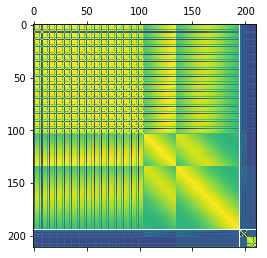

In [16]:
# show feature correlation plot

import matplotlib.pyplot as plt

plt.matshow(X_train.corr())
plt.show()